# Epitopes encoding

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import warnings
from pathlib import Path
import os
import sys

# libs for ml
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

warnings.filterwarnings('ignore')
current_file_path = os.getcwd()
project_root =  os.path.dirname(os.path.dirname(current_file_path))
sys.path.append(str(project_root))

# my module with some func
import modules.modules_onehot.pepcode as pepcode

## Set Parameters:

In [2]:
AA_LIST = pepcode.AA_LIST

latent_dims = 64
num_epochs = 200
batch_size = 400
learning_rate = 1e-4 
use_gpu = True

# Device set
if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

sns.set_theme(style="darkgrid")
default_color = "xkcd:dark pastel green"

## Preparing data

In [3]:
# Load dataset of Epitopes from IEDB
ep_data = pd.read_csv('../../dataset/epitopes_for_train/epitope_clean.csv')
#Filter
ep_data = ep_data[(ep_data['Epitope - Object Type'] == 'Linear peptide') & (ep_data['Epitope - Species'] == 'Homo sapiens')]
epitopes = ep_data['Epitope - Name']
epitopes = epitopes[~epitopes.str.contains(r'[a-z()0-9\s]')] # To remove some strange rows
epitopes = epitopes[~epitopes.str.contains(r'X')]
epitopes = epitopes[(epitopes.str.len() >= 6) & (epitopes.str.len() <= 20)]
# Load negative data
neg_data = pd.read_csv('../../dataset/negative_data/negative_data.csv')
# Concat negative epitopes list (from VDJdb) and Epitopes from IEDB
epitopes = pd.DataFrame(pd.concat([epitopes, neg_data['antigen_epitope']], ignore_index=True),columns=['antigen_epitope'])

# Split datasets
epitopes = shuffle(epitopes)
epitopes.reset_index(drop=True, inplace=True)
train_size, test_size, eval_size = int(round(len(epitopes)*0.7, 0)), int(round(len(epitopes)*(0.7+0.15), 0)), int(round(len(epitopes)*(1), 0))
data_split = np.split(epitopes, [train_size, test_size, eval_size], axis=0)
data_train = data_split[0]
data_test = data_split[1]
data_eval = data_split[2]

# Prepare peptide lists
pep_train_list_ori = data_train.antigen_epitope.values
pep_test_list_ori = data_test.antigen_epitope.values
pep_eval_list_ori = data_eval.antigen_epitope.values

# Gap insertion
pep_train_list = []
for seq in pep_train_list_ori:
    gap_count = 20-len(seq) # max_len = 19
    pep_train_list.append(seq[0:3]+'-'*gap_count+seq[3:])
    pep_train_list.append(seq[0:4]+'-'*gap_count+seq[4:])
    pep_train_list.append(seq[0:-3]+'-'*gap_count+seq[-3:])
    pep_train_list.append(seq[0:-4]+'-'*gap_count+seq[-4:])
    
pep_test_list = []
for seq in pep_test_list_ori:
    gap_count = 20-len(seq) # max_len = 19
    pep_test_list.append(seq[0:3]+'-'*gap_count+seq[3:])
    pep_test_list.append(seq[0:4]+'-'*gap_count+seq[4:])
    pep_test_list.append(seq[0:-3]+'-'*gap_count+seq[-3:])
    pep_test_list.append(seq[0:-4]+'-'*gap_count+seq[-4:])

pep_eval_list = []
for seq in pep_eval_list_ori:
    gap_count = 20-len(seq) # max_len = 19
    pep_eval_list.append(seq[0:3]+'-'*gap_count+seq[3:])
    pep_eval_list.append(seq[0:4]+'-'*gap_count+seq[4:])
    pep_eval_list.append(seq[0:-3]+'-'*gap_count+seq[-3:])
    pep_eval_list.append(seq[0:-4]+'-'*gap_count+seq[-4:])


len_seq = len(pep_train_list[0])

#Convert to One-hot
pep_train_oh = np.zeros((len(pep_train_list), len(AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_train_oh)):
    pep_train_oh[i] = pepcode.one_hot_code(pep_train_list[i])

pep_test_oh = np.zeros((len(pep_test_list), len(AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_test_list)):
    pep_test_oh[i] = pepcode.one_hot_code(pep_test_list[i])  

pep_eval_oh = np.zeros((len(pep_eval_list), len(AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_eval_list)):
    pep_eval_oh[i] = pepcode.one_hot_code(pep_eval_list[i])  


oh_matr_size = pep_test_oh[0].size


# Prepare train dataloader
oh_dataset_train = torch.utils.data.TensorDataset(torch.tensor(pep_train_oh), torch.tensor(np.ones(pep_train_oh.shape[0])))
oh_train_dl = torch.utils.data.DataLoader(oh_dataset_train, batch_size=batch_size, shuffle=False)

# Prepare test dataloader
oh_dataset_test = torch.utils.data.TensorDataset(torch.tensor(pep_test_oh), torch.tensor(np.ones(pep_test_oh.shape[0])))
oh_test_dl = torch.utils.data.DataLoader(oh_dataset_test, batch_size=batch_size, shuffle=False)

# Evaluation
oh_dataset_eval = torch.utils.data.TensorDataset(torch.tensor(pep_eval_oh), torch.tensor(np.ones(pep_eval_oh.shape[0])))
oh_eval_dl = torch.utils.data.DataLoader(oh_dataset_eval, batch_size=batch_size, shuffle=False)



## Autoencoder class definition

In [4]:
autoencoder_arch = f'{oh_matr_size}->{latent_dims}'

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=oh_matr_size, out_features=latent_dims),
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dims, out_features=oh_matr_size),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encoding(self, x):
        encoded = self.encoder(x)
        return encoded

    def decoding(self, encoded):
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = learning_rate)

### Train autoencoder

In [5]:
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_train_dl:
        
        pep_batch = pep_batch.to(device)
        pep_batch_o = pep_batch
        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        pep_batch_recon = autoencoder(pep_batch)
        pep_batch_recon_rsh = pep_batch_recon.reshape(pep_batch_o.shape)

        # reconstruction error
        loss = loss_function(pep_batch_recon_rsh, pep_batch_o)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    train_loss_avg[-1] /= num_batches
    
    if epoch % 40 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
print('Train finished')

Training ...
Epoch [1 / 200] average reconstruction error: 1.942512
Epoch [41 / 200] average reconstruction error: 0.093120
Epoch [81 / 200] average reconstruction error: 0.059360
Epoch [121 / 200] average reconstruction error: 0.042516
Epoch [161 / 200] average reconstruction error: 0.031632
Train finished


### Evaluation on test set

In [6]:
autoencoder.eval()

output = []
test_loss_avg, num_batches = 0, 0

for (pep, _) in oh_test_dl:
    with torch.no_grad():
        pep_o = pep
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_o = pep_o.to(device)
        pep_recon = autoencoder(pep)
        pep_recon_rs = pep_recon.reshape(pep_o.shape)
        loss = loss_function(pep_recon_rs, pep_o)
        test_loss_avg += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg /= num_batches

print('Average reconstruction error: %f' % (test_loss_avg))

# Results back to sequence
pep_test_oh_bef = np.zeros((len(pep_test_list), len(AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(AA_LIST), len_seq), dtype = np.float32)

pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    
pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))  
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.048132


### Biological evaluation

In [7]:
gap_dict_before = {key: 0 for key in range(len_seq)}
gap_dict_after = {key: 0 for key in range(len_seq)}

# Gaps distribution
for i in range(len(pep_test_list_bef_ae)):
    for j in range(0, len_seq):
        aa_before = pep_test_list_bef_ae[i][j]
        aa_after = pep_test_list_aft_ae[i][j]
        #Gaps count
        if aa_before == '-':
            gap_dict_before[j] += 1
        if aa_after == '-':
            gap_dict_after[j] += 1


# Remove gaps from sequence and choose the hight freq. variant
pep_test_list_bef_no_gap = []
pep_test_list_aft_no_gap = []
for i in range(0, len(pep_test_list_bef_ae), 4):
    pep_test_list_bef_no_gap.append(pep_test_list_bef_ae[i].replace('-', ''))
    var = []
    var.append(pep_test_list_aft_ae[i].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+1].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+2].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+3].replace('-', ''))
    c = Counter(var)
    pep_test_list_aft_no_gap.append(c.most_common(1)[0][0])


# Compare lenght of sequence after reconstruction
new_seq_lens_dict = {}
for i in range(len(pep_test_list_bef_no_gap)):
    len_before = len(pep_test_list_bef_no_gap[i])
    len_after = len(pep_test_list_aft_no_gap[i])
    if len_before != len_after:
        if (f'{len_before}'+f'-{len_after}') in new_seq_lens_dict.keys():
            new_seq_lens_dict[f'{len_before}'+f'-{len_after}'] += 1
        else:
            new_seq_lens_dict[f'{len_before}'+f'-{len_after}'] = 1
new_seq_lens_dict = dict(sorted(new_seq_lens_dict.items(), key=lambda item: item[1]))



err_seq_dict = {}
err_count_no_gap_ce = {key/100.0: 0 for key in range(0, 100, 5)}
pos_lst = np.asarray(list(err_count_no_gap_ce.keys()))
err_dict_no_gap = {}
counter = 0

pep_test_list_bef_ae_no_gap_aa = []
pep_test_list_aft_ae_no_gap_aa = []


for i in range(len(pep_test_list_bef_no_gap)):
    seq_before = pep_test_list_bef_no_gap[i]
    seq_after = pep_test_list_aft_no_gap[i]
    
    # Save sequences with different lenght
    if len(seq_after) != len(seq_before):
        err_seq_dict[seq_before] = seq_after
        continue
        
    # Save number of right lenght sequences
    counter += 1

    # Compare the right lenght sequences
    for j in range(len(seq_before)):
        aa_before = seq_before[j]
        aa_after = seq_after[j]

        
        if aa_before != aa_after:
            err_rel_pos = round(j/len(seq_before),2)
            idx = (np.abs(pos_lst - err_rel_pos)).argmin()
            target_pos = pos_lst[idx]
            err_count_no_gap_ce[target_pos] += 1 
            
            if aa_before+aa_after in err_dict_no_gap.keys():
                err_dict_no_gap[aa_before+aa_after] += 1
            else:
                err_dict_no_gap[aa_before+aa_after] = 1
        # For classification report only
        pep_test_list_bef_ae_no_gap_aa.append(aa_before)
        pep_test_list_aft_ae_no_gap_aa.append(aa_after)

err_count_perc_ce = {key/100.0: 0 for key in range(0, 100, 5)}
for key, val in err_count_no_gap_ce.items():
    err_count_perc_ce[key] = val/counter*100


err_dict_no_gap = dict(sorted(err_dict_no_gap.items(), key=lambda item: item[1]))

print(f'From {len(pep_test_list_bef_no_gap)} sequences with right seq len:{counter}. Different lenghts: {new_seq_lens_dict}')

From 17332 sequences with right seq len:17290. Different lenghts: {'20-18': 1, '13-12': 1, '17-16': 1, '16-17': 1, '15-16': 1, '18-17': 1, '19-18': 2, '15-14': 2, '17-18': 2, '18-19': 4, '16-15': 4, '19-20': 9, '20-19': 13}


#### Gap distribution

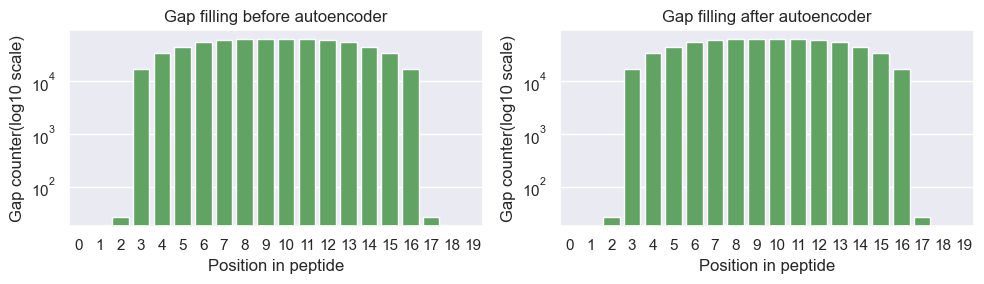

In [8]:
fig, axs = plt.subplots(1, 2,  figsize = [10, 3])
sns.barplot(gap_dict_before, color = default_color, ax=axs[0])
axs[0].set_yscale("log")
sns.barplot(gap_dict_after, color = default_color, ax=axs[1])
axs[1].set_yscale("log")
axs[0].set(title='Gap filling before autoencoder', xlabel='Position in peptide', ylabel='Gap counter(log10 scale)')
axs[1].set(title='Gap filling after autoencoder', xlabel='Position in peptide', ylabel='Gap counter(log10 scale)')
plt.tight_layout()
plt.show()

#### Main report

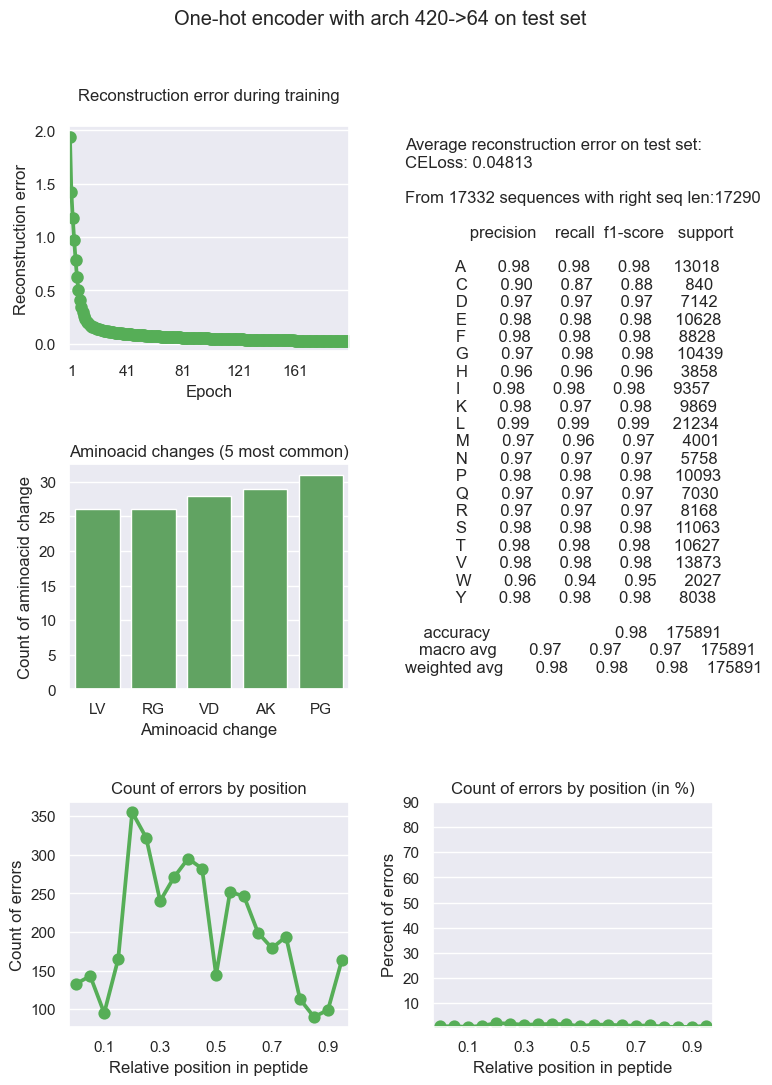

In [9]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])

sns.pointplot(train_loss_avg , color = default_color, ax=axs[0, 0], markersize=7)
sns.barplot(dict(list(err_dict_no_gap.items())[-5:]), color = default_color, ax=axs[1, 0])
sns.pointplot(err_count_no_gap_ce, color = default_color, ax=axs[2, 0])
sns.pointplot(err_count_perc_ce, color = default_color, ax=axs[2, 1])

axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n', xticks=[i for i in range(1, num_epochs, int(num_epochs/5))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=-0.1, y=-1.5, s=f'Average reconstruction error on test set:\nCELoss: {round(test_loss_avg, 5)}\n\nFrom {len(pep_test_list_bef_no_gap)} sequences with right seq len:{counter}\n\n{classification_report(pep_test_list_bef_ae_no_gap_aa, pep_test_list_aft_ae_no_gap_aa)}')
axs[1, 0].set(xlabel='Aminoacid change', ylabel='Count of aminoacid change', title=f'Aminoacid changes (5 most common)')
axs[1, 1].set(frame_on=False)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[2, 0].set(xlabel='Relative position in peptide', ylabel='Count of errors', title=f'Count of errors by position')
axs[2, 1].set(xlabel='Relative position in peptide', ylabel='Percent of errors', title=f'Count of errors by position (in %)', yticks=[i*10 for i in range(1, 10)])
axs[2, 0].set_xticks([2,6,10,14,18])
axs[2, 1].set_xticks([2,6,10,14,18])

plt.subplots_adjust(wspace=0.3, hspace=0.5)
fig.suptitle(f'One-hot encoder with arch {autoencoder_arch} on test set') 
plt.show()
#fig.savefig(f'../../results/results_onehot/{str(date.today())}_{autoencoder_arch}_on_test_CELoss_final.pdf', format='pdf')